In [1]:
import pandas as pd
import numpy as np 
import networkx as nx
import matplotlib.pyplot as plt
import tqdm
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import torch
from torch import Tensor
import torch.nn as nn
from torch.nn import Linear
import torch.nn.functional as F

import torch_geometric as pyg
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader, LinkNeighborLoader
import torch_geometric.transforms as T
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.nn import SAGEConv, GCNConv, Node2Vec
from torch_geometric.utils import to_networkx, negative_sampling, train_test_split_edges

#from node2vec import Node2Vec

In [2]:
node_df = pd.read_csv(r"C:\Users\wchen\OneDrive - Dartmouth College\Dartmouth\QSS82\spotify\nodes.csv")
edges_df = pd.read_csv(r"C:\Users\wchen\OneDrive - Dartmouth College\Dartmouth\QSS82\spotify\edges.csv")

## Process Node Attributes

In [3]:
node_df["genres"] = node_df["genres"].apply(lambda x: x[1:-1].strip())
#node_df["genres"] = node_df["genres"].apply(lambda x: x.split(','))
node_df["n_genres"] = node_df["genres"].apply(lambda x: 0 if len(x)==0 else len(x.split(',')))
node_df["spotify_id"] = node_df["spotify_id"].astype(str)
#node_df.reset_index(inplace=True)

In [4]:
# Remove artists with no followers 
node_df.drop(node_df.loc[node_df['followers']==0].index, inplace=True)

In [5]:
# Normalize popularity and follower features
node_df["popularity_norm"] = MinMaxScaler().fit_transform(node_df[["popularity"]])
node_df["log_followers"] = np.log(node_df["followers"])

In [6]:
node_df["n_genres"].describe()

count    148328.000000
mean          0.745287
std           1.356849
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          16.000000
Name: n_genres, dtype: float64

In [7]:
node_df.loc[node_df["n_genres"]==0]

,spotify_id,name,followers,popularity,genres,chart_hits,n_genres,popularity_norm,log_followers
2,652XIvIBNGg3C0KIGEJWit,Maxim,34596.0,36,,['de (1)'],0,0.36,10.451493
5,0FQMb3mVrAKlyU4H5mQOJh,Madh,26677.0,19,,['it (2)'],0,0.19,10.191557
9,5I82NM6jN4Y267iHwVeNR9,Nata Record,188.0,12,,['do (1)'],0,0.12,5.236442
14,5RYLofQHxZcrEl9Bl23MCS,MaRina,6408.0,29,,['pl (1)'],0,0.29,8.765302
15,3xs0LEzcPXtgNfMNcHzLIP,Rockwell,40344.0,58,,"['us (1)', 'gb (1)', 'at (1)', 'be (1)', 'ca (...",0,0.58,10.605198
...,...,...,...,...,...,...,...,...,...
156416,3tN8Pno7EAzcF3enqAufA7,J.D.B,204.0,30,,NaN,0,0.30,5.318120
156418,6AeznZajNbXUulT7W4tK5l,Darmiko,2022.0,23,,NaN,0,0.23,7.611842
156419,3GEijIjrgb4lPe9WtURBzz,Katriell,268.0,0,,NaN,0,0.00,5.590987
156420,0ldQL0icSoMz9OOZcWG8Zt,Yung Fresh,181.0,19,,NaN,0,0.19,5.198497


In [8]:
# Data on each artist 
node_df

,spotify_id,name,followers,popularity,genres,chart_hits,n_genres,popularity_norm,log_followers
0,48WvrUGoijadXXCsGocwM4,Byklubben,1738.0,24,"'nordic house', 'russelater'",['no (3)'],2,0.24,7.460490
1,4lDiJcOJ2GLCK6p9q5BgfK,Kontra K,1999676.0,72,"'christlicher rap', 'german hip hop'","['at (44)', 'de (111)', 'lu (22)', 'ch (31)', ...",2,0.72,14.508496
2,652XIvIBNGg3C0KIGEJWit,Maxim,34596.0,36,,['de (1)'],0,0.36,10.451493
3,3dXC1YPbnQPsfHPVkm1ipj,Christopher Martin,249233.0,52,"'dancehall', 'lovers rock', 'modern reggae', '...","['at (1)', 'de (1)']",4,0.52,12.426143
4,74terC9ol9zMo8rfzhSOiG,Jakob Hellman,21193.0,39,"'classic swedish pop', 'norrbotten indie', 'sw...",['se (6)'],3,0.39,9.961426
...,...,...,...,...,...,...,...,...,...
156417,2ces6d2YsQP1RpGMYpdFy8,David Urwitz,5470.0,29,'classic swedish pop',NaN,1,0.29,8.607034
156418,6AeznZajNbXUulT7W4tK5l,Darmiko,2022.0,23,,NaN,0,0.23,7.611842
156419,3GEijIjrgb4lPe9WtURBzz,Katriell,268.0,0,,NaN,0,0.00,5.590987
156420,0ldQL0icSoMz9OOZcWG8Zt,Yung Fresh,181.0,19,,NaN,0,0.19,5.198497


In [9]:
node_df.shape

(148328, 9)

In [10]:
node_df["followers"].describe()

count    1.483240e+05
mean     9.092892e+04
std      9.651885e+05
min      1.000000e+00
25%      3.800000e+01
50%      4.760000e+02
75%      7.384000e+03
max      1.021569e+08
Name: followers, dtype: float64

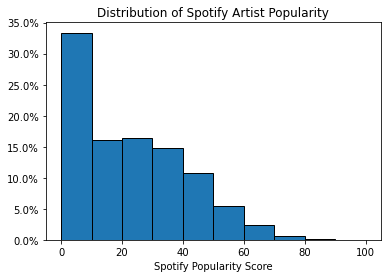

In [11]:
# Distribution of artist popularity
from matplotlib.ticker import PercentFormatter


plt.hist(node_df["popularity"], weights=np.ones(len(node_df)) / len(node_df), edgecolor='black')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel("Spotify Popularity Score")
plt.title("Distribution of Spotify Artist Popularity")
plt.show()

In [12]:
node_df.loc[node_df["n_genres"]>0]

,spotify_id,name,followers,popularity,genres,chart_hits,n_genres,popularity_norm,log_followers
0,48WvrUGoijadXXCsGocwM4,Byklubben,1738.0,24,"'nordic house', 'russelater'",['no (3)'],2,0.24,7.460490
1,4lDiJcOJ2GLCK6p9q5BgfK,Kontra K,1999676.0,72,"'christlicher rap', 'german hip hop'","['at (44)', 'de (111)', 'lu (22)', 'ch (31)', ...",2,0.72,14.508496
3,3dXC1YPbnQPsfHPVkm1ipj,Christopher Martin,249233.0,52,"'dancehall', 'lovers rock', 'modern reggae', '...","['at (1)', 'de (1)']",4,0.52,12.426143
4,74terC9ol9zMo8rfzhSOiG,Jakob Hellman,21193.0,39,"'classic swedish pop', 'norrbotten indie', 'sw...",['se (6)'],3,0.39,9.961426
6,71BhXa24Zf5zcikUb00l2N,Juice,11312.0,37,"'swedish drill', 'swedish hip hop', 'swedish t...",['se (4)'],4,0.37,9.333619
...,...,...,...,...,...,...,...,...,...
156392,6HRnGwZ87Xob0I0cHSvr0s,Sevda Alekperzadeh,5634.0,8,'azeri pop',NaN,1,0.08,8.636575
156396,0By75sLZQ06mWyzNiSdLUB,Menor,26346.0,39,'funk carioca',NaN,1,0.39,10.179072
156402,7vlW9kOjO3ioYJ0k0P6xCG,Grupo Los Generales,2226.0,33,'corrido',NaN,1,0.33,7.707962
156413,6mrB3jdXxZq1dl8m8eOVFh,Getamilli,337.0,16,'ritmo kombina',NaN,1,0.16,5.820083


In [13]:
node_df = node_df.loc[node_df["popularity"]>=75]
node_df

,spotify_id,name,followers,popularity,genres,chart_hits,n_genres,popularity_norm,log_followers
23,6M2wZ9GZgrQXHCFfjv46we,Dua Lipa,36163788.0,88,"'dance pop', 'pop', 'uk pop'","['us (17)', 'gb (25)', 'ar (18)', 'au (20)', '...",3,0.88,17.403569
137,23fqKkggKUBHNkbKtXEls4,Kygo,8134874.0,80,"'edm', 'pop', 'pop dance', 'tropical house'","['us (28)', 'gb (24)', 'ar (9)', 'au (24)', 'a...",4,0.80,15.911671
230,360IAlyVv4PCEVjgyMZrxK,Miguel,4195623.0,77,"'dance pop', 'pop', 'r&b', 'urban contemporary'","['us (10)', 'gb (1)', 'ar (1)', 'au (4)', 'be ...",4,0.77,15.249552
242,4kYSro6naA4h99UJvo89HB,Cardi B,20361435.0,80,"'dance pop', 'pop', 'rap'","['us (19)', 'gb (17)', 'ar (2)', 'au (16)', 'a...",3,0.80,16.829153
273,5f7VJjfbwm532GiveGC0ZK,Lil Baby,11530234.0,89,"'atl hip hop', 'atl trap', 'rap', 'trap'","['us (62)', 'gb (16)', 'au (6)', 'at (3)', 'be...",4,0.89,16.260483
...,...,...,...,...,...,...,...,...,...
68754,3xvaSlT4xsyk6lY1ESOspO,Disney,225230.0,82,,NaN,0,0.82,12.324877
77196,1dABGukgZ8XKKOdd2rVSHM,Lofi Fruits Music,634698.0,77,"'lo-fi cover', 'lo-fi product'",NaN,2,0.77,13.360905
95291,4NJhFmfw43RLBLjQvxDuRS,Wolfgang Amadeus Mozart,4658811.0,75,"'classical', 'classical era'",NaN,2,0.75,15.354271
116138,1r1uxoy19fzMxunt3ONAkG,Phoebe Bridgers,1329697.0,75,"'indie pop', 'la indie'",NaN,2,0.75,14.100462


In [14]:
# Generate dummy variables for each music genre 
genres = node_df['genres'].str.get_dummies(', ')
genres

,'afro dancehall','afro r&b','afrofuturism','afropop','album rock','alt z','alte','alternative dance','alternative hip hop','alternative metal',...,'underground hip hop','urban contemporary','urbano chileno','urbano espanol','video game music','viral pop','viral rap','west coast rap','yacht rock','yakut pop'
23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
137,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
230,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
242,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
273,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68754,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
77196,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95291,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
116138,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
genre_sum = genres.sum(axis=0)
genre_sum

'afro dancehall'    2
'afro r&b'          1
'afrofuturism'      2
'afropop'           1
'album rock'        5
                   ..
'viral pop'         4
'viral rap'         1
'west coast rap'    5
'yacht rock'        2
'yakut pop'         1
Length: 395, dtype: int64

In [16]:
genre_sum = pd.DataFrame(genre_sum)
genre_sum.columns = ["count"]
genre_sum

,count
'afro dancehall',2
'afro r&b',1
'afrofuturism',2
'afropop',1
'album rock',5
...,...
'viral pop',4
'viral rap',1
'west coast rap',5
'yacht rock',2


array([[<AxesSubplot:title={'center':'count'}>]], dtype=object)

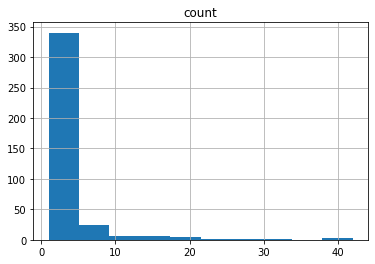

In [17]:
genre_sum[genre_sum["count"]<50].hist()

array([[<AxesSubplot:title={'center':'count'}>]], dtype=object)

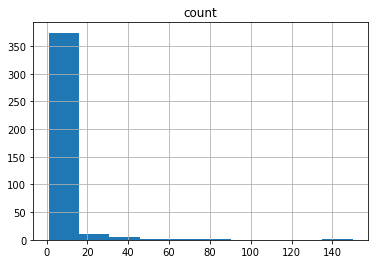

In [18]:
genre_sum.hist()

In [19]:
trivial = list(genre_sum.loc[genre_sum["count"]<5].index)

In [20]:
non_trivial_genres = genres.drop(trivial, axis=1, inplace=False)
non_trivial_genres

,'album rock','alternative metal','alternative rock','argentine hip hop','arrocha','art pop','atl hip hop','canadian pop','chicago rap','classic rock',...,'soft rock','southern hip hop','trap argentino','trap latino','trap','tropical house','uk dance','uk pop','urban contemporary','west coast rap'
23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
137,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
230,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
242,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
273,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68754,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
77196,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95291,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
116138,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
non_trivial_genres["tot_genres"] = non_trivial_genres.sum(axis=1)

In [22]:
non_trivial_genres.sum(axis=0)

'album rock'               5
'alternative metal'        9
'alternative rock'         6
'argentine hip hop'        6
'arrocha'                  9
                        ... 
'uk dance'                 7
'uk pop'                  32
'urban contemporary'      15
'west coast rap'           5
tot_genres              1175
Length: 69, dtype: int64

In [23]:
non_trivial_genres[["tot_genres"]]

,tot_genres
23,3
137,4
230,4
242,3
273,3
...,...
68754,0
77196,0
95291,0
116138,0


In [24]:
gens = list(non_trivial_genres.columns)
genre_dict = {}
for i in range(len(gens)-1):
    genre_dict[gens[i]] = i

In [25]:
node_df = pd.concat([node_df, non_trivial_genres], axis = 1)
node_df

,spotify_id,name,followers,popularity,genres,chart_hits,n_genres,popularity_norm,log_followers,'album rock',...,'southern hip hop','trap argentino','trap latino','trap','tropical house','uk dance','uk pop','urban contemporary','west coast rap',tot_genres
23,6M2wZ9GZgrQXHCFfjv46we,Dua Lipa,36163788.0,88,"'dance pop', 'pop', 'uk pop'","['us (17)', 'gb (25)', 'ar (18)', 'au (20)', '...",3,0.88,17.403569,0,...,0,0,0,0,0,0,1,0,0,3
137,23fqKkggKUBHNkbKtXEls4,Kygo,8134874.0,80,"'edm', 'pop', 'pop dance', 'tropical house'","['us (28)', 'gb (24)', 'ar (9)', 'au (24)', 'a...",4,0.80,15.911671,0,...,0,0,0,0,1,0,0,0,0,4
230,360IAlyVv4PCEVjgyMZrxK,Miguel,4195623.0,77,"'dance pop', 'pop', 'r&b', 'urban contemporary'","['us (10)', 'gb (1)', 'ar (1)', 'au (4)', 'be ...",4,0.77,15.249552,0,...,0,0,0,0,0,0,0,1,0,4
242,4kYSro6naA4h99UJvo89HB,Cardi B,20361435.0,80,"'dance pop', 'pop', 'rap'","['us (19)', 'gb (17)', 'ar (2)', 'au (16)', 'a...",3,0.80,16.829153,0,...,0,0,0,0,0,0,0,0,0,3
273,5f7VJjfbwm532GiveGC0ZK,Lil Baby,11530234.0,89,"'atl hip hop', 'atl trap', 'rap', 'trap'","['us (62)', 'gb (16)', 'au (6)', 'at (3)', 'be...",4,0.89,16.260483,0,...,0,0,0,1,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68754,3xvaSlT4xsyk6lY1ESOspO,Disney,225230.0,82,,NaN,0,0.82,12.324877,0,...,0,0,0,0,0,0,0,0,0,0
77196,1dABGukgZ8XKKOdd2rVSHM,Lofi Fruits Music,634698.0,77,"'lo-fi cover', 'lo-fi product'",NaN,2,0.77,13.360905,0,...,0,0,0,0,0,0,0,0,0,0
95291,4NJhFmfw43RLBLjQvxDuRS,Wolfgang Amadeus Mozart,4658811.0,75,"'classical', 'classical era'",NaN,2,0.75,15.354271,0,...,0,0,0,0,0,0,0,0,0,0
116138,1r1uxoy19fzMxunt3ONAkG,Phoebe Bridgers,1329697.0,75,"'indie pop', 'la indie'",NaN,2,0.75,14.100462,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
node_df = node_df.loc[node_df["tot_genres"]>0]
node_df

,spotify_id,name,followers,popularity,genres,chart_hits,n_genres,popularity_norm,log_followers,'album rock',...,'southern hip hop','trap argentino','trap latino','trap','tropical house','uk dance','uk pop','urban contemporary','west coast rap',tot_genres
23,6M2wZ9GZgrQXHCFfjv46we,Dua Lipa,36163788.0,88,"'dance pop', 'pop', 'uk pop'","['us (17)', 'gb (25)', 'ar (18)', 'au (20)', '...",3,0.88,17.403569,0,...,0,0,0,0,0,0,1,0,0,3
137,23fqKkggKUBHNkbKtXEls4,Kygo,8134874.0,80,"'edm', 'pop', 'pop dance', 'tropical house'","['us (28)', 'gb (24)', 'ar (9)', 'au (24)', 'a...",4,0.80,15.911671,0,...,0,0,0,0,1,0,0,0,0,4
230,360IAlyVv4PCEVjgyMZrxK,Miguel,4195623.0,77,"'dance pop', 'pop', 'r&b', 'urban contemporary'","['us (10)', 'gb (1)', 'ar (1)', 'au (4)', 'be ...",4,0.77,15.249552,0,...,0,0,0,0,0,0,0,1,0,4
242,4kYSro6naA4h99UJvo89HB,Cardi B,20361435.0,80,"'dance pop', 'pop', 'rap'","['us (19)', 'gb (17)', 'ar (2)', 'au (16)', 'a...",3,0.80,16.829153,0,...,0,0,0,0,0,0,0,0,0,3
273,5f7VJjfbwm532GiveGC0ZK,Lil Baby,11530234.0,89,"'atl hip hop', 'atl trap', 'rap', 'trap'","['us (62)', 'gb (16)', 'au (6)', 'at (3)', 'be...",4,0.89,16.260483,0,...,0,0,0,1,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19550,1wZtkThiXbVNtj6hee6dz9,Wisin & Yandel,5655168.0,79,"'electro latino', 'latin hip hop', 'reggaeton'...","['ar (5)', 'bo (7)', 'cl (13)', 'co (8)', 'cr ...",4,0.79,15.548080,0,...,0,0,1,0,0,0,0,0,0,3
62564,2fMqTqiTxUDlmcOEPaQSsx,Amitabh Bhattacharya,28232.0,75,'modern bollywood',NaN,1,0.75,10.248211,0,...,0,0,0,0,0,0,0,0,0,1
63462,1Oa0bMld0A3u5OTYfMzp5h,Nate Dogg,1300744.0,75,"'g funk', 'gangster rap', 'hip hop', 'pop rap'...",NaN,6,0.75,14.078447,0,...,0,0,0,0,0,0,0,0,1,5
68244,2ae6PxICSOZHvjqiCcgon8,S. P. Balasubrahmanyam,5086667.0,75,'filmi',NaN,1,0.75,15.442133,0,...,0,0,0,0,0,0,0,0,0,1


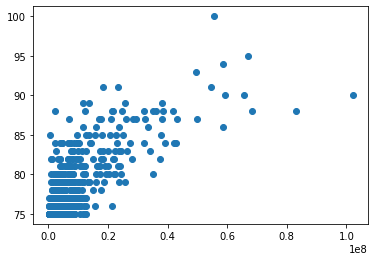

In [27]:
# Correlation between followers and popularity
node_df["followers"].corr(node_df["popularity"])
plt.scatter(node_df["followers"], node_df["popularity"])

Logarithmic relationship between followers and popularity

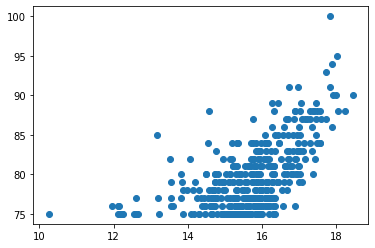

In [28]:
nonzero_nodes = node_df.loc[node_df["followers"]>0]
plt.scatter(np.log(nonzero_nodes["followers"]), nonzero_nodes["popularity"])
plt.show()

In [29]:
node_df["popularity"].corr(node_df["log_followers"])

0.581405286083633

In [30]:
node_df.reset_index(inplace=True)
node_df.reset_index(inplace=True)

In [31]:
node_df

,level_0,index,spotify_id,name,followers,popularity,genres,chart_hits,n_genres,popularity_norm,...,'southern hip hop','trap argentino','trap latino','trap','tropical house','uk dance','uk pop','urban contemporary','west coast rap',tot_genres
0,0,23,6M2wZ9GZgrQXHCFfjv46we,Dua Lipa,36163788.0,88,"'dance pop', 'pop', 'uk pop'","['us (17)', 'gb (25)', 'ar (18)', 'au (20)', '...",3,0.88,...,0,0,0,0,0,0,1,0,0,3
1,1,137,23fqKkggKUBHNkbKtXEls4,Kygo,8134874.0,80,"'edm', 'pop', 'pop dance', 'tropical house'","['us (28)', 'gb (24)', 'ar (9)', 'au (24)', 'a...",4,0.80,...,0,0,0,0,1,0,0,0,0,4
2,2,230,360IAlyVv4PCEVjgyMZrxK,Miguel,4195623.0,77,"'dance pop', 'pop', 'r&b', 'urban contemporary'","['us (10)', 'gb (1)', 'ar (1)', 'au (4)', 'be ...",4,0.77,...,0,0,0,0,0,0,0,1,0,4
3,3,242,4kYSro6naA4h99UJvo89HB,Cardi B,20361435.0,80,"'dance pop', 'pop', 'rap'","['us (19)', 'gb (17)', 'ar (2)', 'au (16)', 'a...",3,0.80,...,0,0,0,0,0,0,0,0,0,3
4,4,273,5f7VJjfbwm532GiveGC0ZK,Lil Baby,11530234.0,89,"'atl hip hop', 'atl trap', 'rap', 'trap'","['us (62)', 'gb (16)', 'au (6)', 'at (3)', 'be...",4,0.89,...,0,0,0,1,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,402,19550,1wZtkThiXbVNtj6hee6dz9,Wisin & Yandel,5655168.0,79,"'electro latino', 'latin hip hop', 'reggaeton'...","['ar (5)', 'bo (7)', 'cl (13)', 'co (8)', 'cr ...",4,0.79,...,0,0,1,0,0,0,0,0,0,3
403,403,62564,2fMqTqiTxUDlmcOEPaQSsx,Amitabh Bhattacharya,28232.0,75,'modern bollywood',NaN,1,0.75,...,0,0,0,0,0,0,0,0,0,1
404,404,63462,1Oa0bMld0A3u5OTYfMzp5h,Nate Dogg,1300744.0,75,"'g funk', 'gangster rap', 'hip hop', 'pop rap'...",NaN,6,0.75,...,0,0,0,0,0,0,0,0,1,5
405,405,68244,2ae6PxICSOZHvjqiCcgon8,S. P. Balasubrahmanyam,5086667.0,75,'filmi',NaN,1,0.75,...,0,0,0,0,0,0,0,0,0,1


In [32]:
node_df["followers_norm"]=MinMaxScaler().fit_transform(node_df[["log_followers"]])

C:\Users\wchen\AppData\Local\Temp/ipykernel_6964/4147512650.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  node_df["followers_norm"]=MinMaxScaler().fit_transform(node_df[["log_followers"]])


<AxesSubplot:>

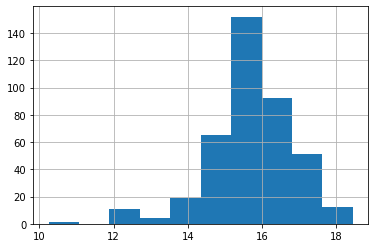

In [33]:
node_df["log_followers"].hist()

In [34]:
features = list(non_trivial_genres.columns)[:-1]
features.append("popularity_norm")
features.append("followers_norm")

In [35]:
#node_ids = node_df["spotify_id"]
node_attrs = torch.tensor(node_df[features].values, dtype=torch.float)

In [36]:
# FUll dataset: 156222
len(node_attrs)

407

In [37]:
node_attrs.shape

torch.Size([407, 70])

In [35]:
node_df.loc[node_df["spotify_id"]=="4N0EUas6rgOC46pdItA4lS"].index.values[0]

IndexError: index 0 is out of bounds for axis 0 with size 0

## Process Node Connections

In [38]:
# Edge list of collaborations between artists 
edges_df

,id_0,id_1
0,76M2Ekj8bG8W7X2nbx2CpF,7sfl4Xt5KmfyDs2T3SVSMK
1,0hk4xVujcyOr6USD95wcWb,7Do8se3ZoaVqUt3woqqSrD
2,38jpuy3yt3QIxQ8Fn1HTeJ,4csQIMQm6vI2A2SCVDuM2z
3,6PvcxssrQ0QaJVaBWHD07l,6UCQYrcJ6wab6gnQ89OJFh
4,2R1QrQqWuw3IjoP5dXRFjt,4mk1ScvOUkuQzzCZpT6bc0
...,...,...
300381,0PK0Dx3s9et0Uf4XbdFpiW,6SmpksRq3jxeDZ7roKDb6F
300382,5hqRsNHDZH1jHzI9LgxFRZ,7KYseTkErcYMRvcIqacxUq
300383,0wjb0t7aYMuIwyuXnPOilh,2p1fiYHYiXz9qi0JJyxBzN
300384,3ciRvbBIVz9fBoPbtSYq4x,5einkgXXrjhfYCyac1FANB


In [39]:
artist_key = node_df[["level_0", "spotify_id"]]
artist_key.columns = ["artist1", "id_0"]
artist_key

,artist1,id_0
0,0,6M2wZ9GZgrQXHCFfjv46we
1,1,23fqKkggKUBHNkbKtXEls4
2,2,360IAlyVv4PCEVjgyMZrxK
3,3,4kYSro6naA4h99UJvo89HB
4,4,5f7VJjfbwm532GiveGC0ZK
...,...,...
402,402,1wZtkThiXbVNtj6hee6dz9
403,403,2fMqTqiTxUDlmcOEPaQSsx
404,404,1Oa0bMld0A3u5OTYfMzp5h
405,405,2ae6PxICSOZHvjqiCcgon8


In [40]:
edges_df_merge = edges_df.merge(artist_key, how = 'left', on='id_0', indicator=True)
#artist_key.columns = []
#edges_df_merge = edges_df_merge.merge()

In [41]:
# Remove any connections with unknown artist IDs
# 812 connections removed 
edges_df_merge = edges_df_merge[edges_df_merge['_merge']=='both']
edges_df_merge.drop('_merge', axis=1, inplace=True)
#edges_df.shape[0]-edges_df_merge.shape[0]

In [42]:
edges_df_merge

,id_0,id_1,artist1
6,1bAftSH8umNcGZ0uyV7LMg,1vqR17Iv8VFdzure1TAXEq,276.0
8,1mYsTxnqsietFxj1OgoGbG,7snhzmuew8iLEDxMIhOU1P,184.0
26,2cPqdH7XMvwaBJEVjheH8g,329e4yvIujISKGKz1BZZbO,173.0
54,4DdkRBBYG6Yk9Ka8tdJ9BW,5yPzzu25VzEk8qrGTLIrE1,341.0
68,0VRj0yCOv2FXJNP47XQnx5,64M6ah0SkkRsnPGtGiRAbb,234.0
...,...,...,...
300320,21451j1KhjAiaYKflxBjr1,2R21vXR83lH98kGeO99Y66,208.0
300325,1moxjboGR7GNWYIMWsRjgG,4TvhRzxIL1le2PWCeUqxQw,51.0
300361,0Q8NcsJwoCbZOHHW63su5S,2TQ4CGgxxCWHqa9yYIGDoU,48.0
300371,1elUiq4X7pxej6FRlrEzjM,3FlCKtwOEYQQYyGVEbxG2Z,135.0


In [43]:
# 15621
edges_df_merge.loc[edges_df_merge["artist1"]>406]

,id_0,id_1,artist1


In [44]:
artist_key.columns = ["artist2", "id_1"]
edges_df_merge = edges_df_merge.merge(artist_key, how='left', on = 'id_1', indicator=True)

In [45]:
edges_df_merge = edges_df_merge[edges_df_merge['_merge']=='both']

In [46]:
edges_df_merge

,id_0,id_1,artist1,artist2,_merge
2,2cPqdH7XMvwaBJEVjheH8g,329e4yvIujISKGKz1BZZbO,173.0,150.0,both
4,0VRj0yCOv2FXJNP47XQnx5,64M6ah0SkkRsnPGtGiRAbb,234.0,14.0,both
8,55Aa2cqylxrFIXC767Z865,6LuN9FCkKOj5PcnpouEgny,344.0,195.0,both
12,6ydoSd3N2mwgwBHtF6K7eX,7f5Zgnp2spUuuzKplmRkt7,177.0,400.0,both
13,0hCNtLu0JehylgoiP8L4Gh,246dkjvS1zLTtiykXe5h60,9.0,319.0,both
...,...,...,...,...,...
17011,1RyvyyTE3xzB2ZywiAwp0i,46SHBwWsqBkxI7EeeBEQG7,257.0,220.0,both
17016,2DlGxzQSjYe5N6G9nkYghR,3ipn9JLAPI5GUEo4y4jcoi,261.0,110.0,both
17019,1mcTU81TzQhprhouKaTkpq,4VMYDCV2IEDYJArk749S6m,330.0,22.0,both
17022,17lzZA2AlOHwCwFALHttmp,1l7ZsJRRS8wlW3WfJfPfNS,176.0,375.0,both


In [47]:
# 15621
edges_df_merge.loc[edges_df_merge["artist2"]>406]

,id_0,id_1,artist1,artist2,_merge


In [48]:
edges_df_merge["artist1"].describe()

count    3623.000000
mean      216.865857
std       116.519916
min         0.000000
25%       115.000000
50%       232.000000
75%       323.000000
max       405.000000
Name: artist1, dtype: float64

In [49]:
edges_df_merge.drop(["id_0", "id_1", '_merge'], axis=1, inplace=True)

In [50]:
edges_df_merge

,artist1,artist2
2,173.0,150.0
4,234.0,14.0
8,344.0,195.0
12,177.0,400.0
13,9.0,319.0
...,...,...
17011,257.0,220.0
17016,261.0,110.0
17019,330.0,22.0
17022,176.0,375.0


In [51]:
edges_df2 = edges_df_merge.copy()
edges_df2.columns = ["artist2", "artist1"]
edges_df2

,artist2,artist1
2,173.0,150.0
4,234.0,14.0
8,344.0,195.0
12,177.0,400.0
13,9.0,319.0
...,...,...
17011,257.0,220.0
17016,261.0,110.0
17019,330.0,22.0
17022,176.0,375.0


In [52]:
edges_df_directed = pd.concat([edges_df_merge, edges_df2])
edges_df_directed

,artist1,artist2
2,173.0,150.0
4,234.0,14.0
8,344.0,195.0
12,177.0,400.0
13,9.0,319.0
...,...,...
17011,220.0,257.0
17016,110.0,261.0
17019,22.0,330.0
17022,375.0,176.0


In [53]:
edges = torch.tensor(edges_df_directed.values, dtype=torch.long)
edges

tensor([[173, 150],
        [234,  14],
        [344, 195],
        ...,
        [ 22, 330],
        [375, 176],
        [243, 208]])

## Load Data into Graph

In [265]:
# Create the graph object 
graph = Data(x=node_attrs, edge_index=edges.t().contiguous())

In [55]:
graph.x[0,16]

tensor(0.)

In [56]:
graph

Data(x=[407, 70], edge_index=[2, 7246])

In [57]:
graph.edge_index

tensor([[173, 234, 344,  ...,  22, 375, 243],
        [150,  14, 195,  ..., 330, 176, 208]])

In [230]:
graph.validate(raise_on_error=True)

True

In [59]:
graph.num_nodes
graph.num_edges
graph.num_node_features
graph.has_isolated_nodes()
graph.has_self_loops()
graph.is_directed()

False

In [60]:
def visualize_graph(G, color):
    plt.figure(figsize=(20,20))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False, node_color=color) #, cmap="Set2"
    plt.show()

In [61]:
genre_dict

{"'album rock'": 0,
 "'alternative metal'": 1,
 "'alternative rock'": 2,
 "'argentine hip hop'": 3,
 "'arrocha'": 4,
 "'art pop'": 5,
 "'atl hip hop'": 6,
 "'canadian pop'": 7,
 "'chicago rap'": 8,
 "'classic rock'": 9,
 "'colombian pop'": 10,
 "'contemporary country'": 11,
 "'corrido'": 12,
 "'country'": 13,
 "'dance pop'": 14,
 "'desi pop'": 15,
 "'edm'": 16,
 "'electro house'": 17,
 "'electropop'": 18,
 "'filmi'": 19,
 "'funk carioca'": 20,
 "'gangster rap'": 21,
 "'hard rock'": 22,
 "'hip hop'": 23,
 "'k-pop boy group'": 24,
 "'k-pop'": 25,
 "'latin arena pop'": 26,
 "'latin hip hop'": 27,
 "'latin pop'": 28,
 "'mellow gold'": 29,
 "'melodic rap'": 30,
 "'metropopolis'": 31,
 "'mexican pop'": 32,
 "'miami hip hop'": 33,
 "'modern bollywood'": 34,
 "'modern rock'": 35,
 "'musica mexicana'": 36,
 "'neo mellow'": 37,
 "'norteno'": 38,
 "'nu metal'": 39,
 "'nueva musica mexicana'": 40,
 "'permanent wave'": 41,
 "'pop dance'": 42,
 "'pop nacional'": 43,
 "'pop rap'": 44,
 "'pop'": 45,
 

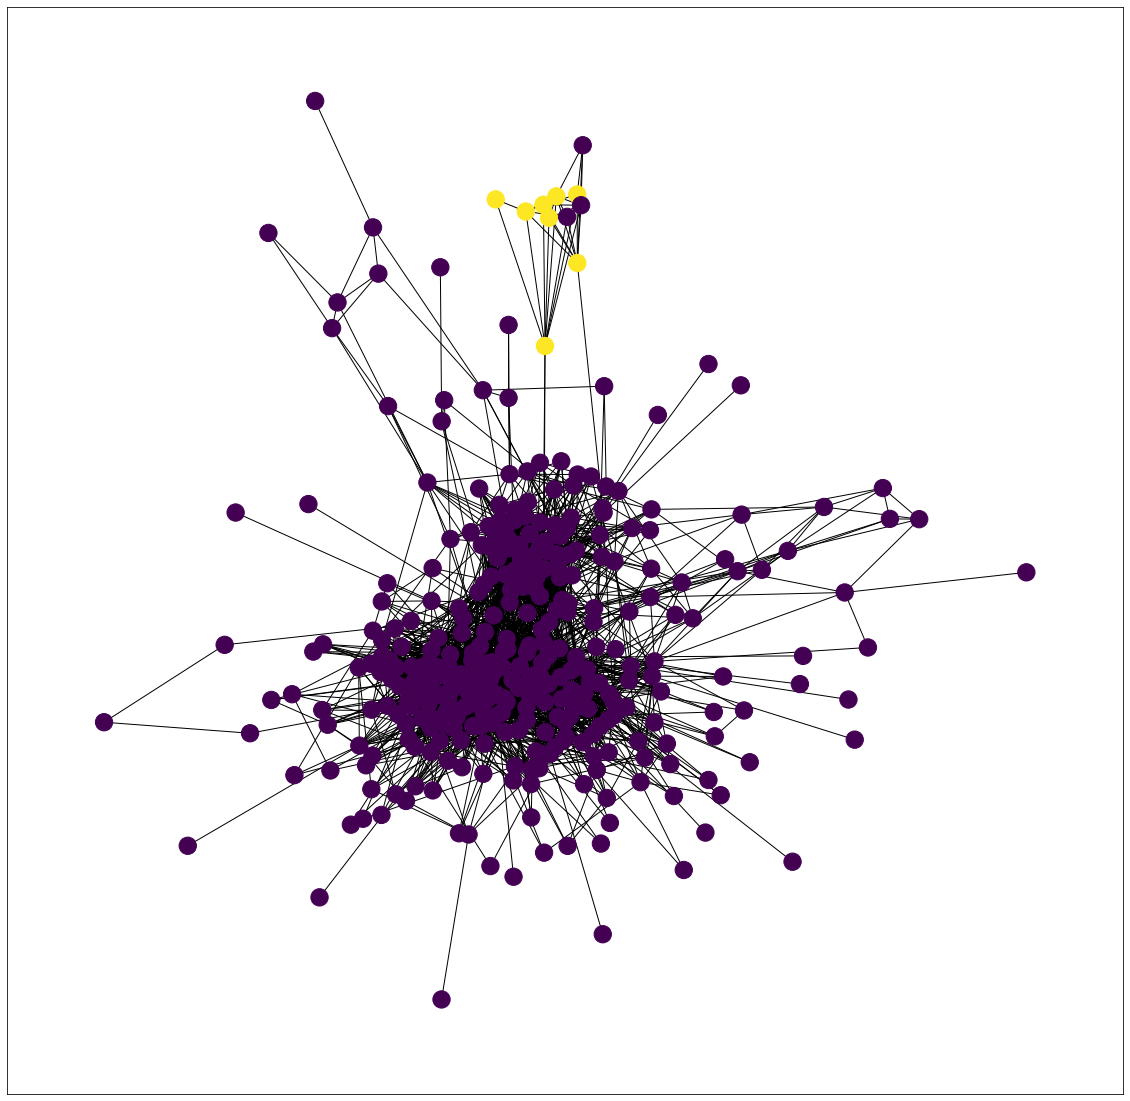

In [62]:
# Visualize the largest connected componenet of the network 
G = to_networkx(graph, to_undirected=True)
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G0 = G.subgraph(Gcc[0])
c_nodes = []
for i in Gcc[0]:
    c_nodes.append(graph.x[i,34].numpy())
visualize_graph(G0, color = c_nodes)

## Centrality Analysis

In [63]:
deg = nx.degree_centrality(G)
eigen = nx.eigenvector_centrality(G)
close = nx.closeness_centrality(G)
between = nx.betweenness_centrality(G)

In [64]:
deg

{0: 0.05172413793103448,
 1: 0.059113300492610835,
 2: 0.07142857142857142,
 3: 0.09359605911330049,
 4: 0.10344827586206896,
 5: 0.05172413793103448,
 6: 0.017241379310344827,
 7: 0.059113300492610835,
 8: 0.0,
 9: 0.1625615763546798,
 10: 0.09605911330049262,
 11: 0.03201970443349754,
 12: 0.0049261083743842365,
 13: 0.014778325123152709,
 14: 0.059113300492610835,
 15: 0.04433497536945813,
 16: 0.0,
 17: 0.0049261083743842365,
 18: 0.007389162561576354,
 19: 0.009852216748768473,
 20: 0.0,
 21: 0.04187192118226601,
 22: 0.10344827586206896,
 23: 0.027093596059113302,
 24: 0.059113300492610835,
 25: 0.0,
 26: 0.009852216748768473,
 27: 0.06157635467980296,
 28: 0.022167487684729065,
 29: 0.0049261083743842365,
 30: 0.0665024630541872,
 31: 0.05665024630541872,
 32: 0.07142857142857142,
 33: 0.0024630541871921183,
 34: 0.08620689655172414,
 35: 0.04187192118226601,
 36: 0.014778325123152709,
 37: 0.0024630541871921183,
 38: 0.014778325123152709,
 39: 0.022167487684729065,
 40: 0.08866

In [65]:
deg_df = pd.DataFrame.from_dict(deg, orient="index", columns = ["deg"])
eigen_df = pd.DataFrame.from_dict(eigen, orient="index", columns = ["eig"])
close_df = pd.DataFrame.from_dict(close, orient="index", columns = ["close"])
bet_df = pd.DataFrame.from_dict(between, orient="index", columns = ["bet"])
centrality_df = pd.concat([deg_df, eigen_df, close_df, bet_df], axis=1)

In [66]:
node_df = pd.concat([node_df, centrality_df], axis=1)
node_df

,level_0,index,spotify_id,name,followers,popularity,genres,chart_hits,n_genres,popularity_norm,...,'uk dance','uk pop','urban contemporary','west coast rap',tot_genres,followers_norm,deg,eig,close,bet
0,0,23,6M2wZ9GZgrQXHCFfjv46we,Dua Lipa,36163788.0,88,"'dance pop', 'pop', 'uk pop'","['us (17)', 'gb (25)', 'ar (18)', 'au (20)', '...",3,0.88,...,0,1,0,0,3,0.873264,0.051724,3.226665e-02,0.383758,0.003608
1,1,137,23fqKkggKUBHNkbKtXEls4,Kygo,8134874.0,80,"'edm', 'pop', 'pop dance', 'tropical house'","['us (28)', 'gb (24)', 'ar (9)', 'au (24)', 'a...",4,0.80,...,0,0,0,0,4,0.691188,0.059113,2.212861e-02,0.368876,0.009298
2,2,230,360IAlyVv4PCEVjgyMZrxK,Miguel,4195623.0,77,"'dance pop', 'pop', 'r&b', 'urban contemporary'","['us (10)', 'gb (1)', 'ar (1)', 'au (4)', 'be ...",4,0.77,...,0,0,1,0,4,0.610381,0.071429,5.798322e-02,0.376395,0.002604
3,3,242,4kYSro6naA4h99UJvo89HB,Cardi B,20361435.0,80,"'dance pop', 'pop', 'rap'","['us (19)', 'gb (17)', 'ar (2)', 'au (16)', 'a...",3,0.80,...,0,0,0,0,3,0.803160,0.093596,7.414282e-02,0.395357,0.007469
4,4,273,5f7VJjfbwm532GiveGC0ZK,Lil Baby,11530234.0,89,"'atl hip hop', 'atl trap', 'rap', 'trap'","['us (62)', 'gb (16)', 'au (6)', 'at (3)', 'be...",4,0.89,...,0,0,0,0,3,0.733758,0.103448,9.412565e-02,0.383758,0.004923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,402,19550,1wZtkThiXbVNtj6hee6dz9,Wisin & Yandel,5655168.0,79,"'electro latino', 'latin hip hop', 'reggaeton'...","['ar (5)', 'bo (7)', 'cl (13)', 'co (8)', 'cr ...",4,0.79,...,0,0,0,0,3,0.646814,0.081281,6.448896e-02,0.365441,0.001756
403,403,62564,2fMqTqiTxUDlmcOEPaQSsx,Amitabh Bhattacharya,28232.0,75,'modern bollywood',NaN,1,0.75,...,0,0,0,0,1,0.000000,0.004926,8.168778e-05,0.225028,0.000000
404,404,63462,1Oa0bMld0A3u5OTYfMzp5h,Nate Dogg,1300744.0,75,"'g funk', 'gangster rap', 'hip hop', 'pop rap'...",NaN,6,0.75,...,0,0,0,1,5,0.467455,0.017241,1.038575e-02,0.304180,0.000019
405,405,68244,2ae6PxICSOZHvjqiCcgon8,S. P. Balasubrahmanyam,5086667.0,75,'filmi',NaN,1,0.75,...,0,0,0,0,1,0.633884,0.009852,1.034250e-05,0.191061,0.000006


In [67]:
node_df["bet"].corr(node_df["popularity"])

0.28586250798499724

In [68]:
node_df.loc[node_df["level_0"]==96]

,level_0,index,spotify_id,name,followers,popularity,genres,chart_hits,n_genres,popularity_norm,...,'uk dance','uk pop','urban contemporary','west coast rap',tot_genres,followers_norm,deg,eig,close,bet
96,96,5161,20sxb77xiYeusSH8cVdatc,Meek Mill,6481503.0,75,"'hip hop', 'philly rap', 'pop rap', 'rap', 'so...","['us (52)', 'gb (8)', 'au (4)', 'at (2)', 'be ...",6,0.75,...,0,0,0,0,5,0.663458,0.115764,0.118894,0.39486,0.003447


In [226]:
nx.voterank(G)

[382,
 80,
 344,
 257,
 150,
 157,
 202,
 309,
 245,
 9,
 386,
 365,
 323,
 91,
 398,
 179,
 325,
 213,
 262,
 115,
 376,
 354,
 388,
 195,
 330,
 233,
 176,
 371,
 283,
 267,
 208,
 156,
 338,
 401,
 303,
 243,
 159,
 174,
 223,
 112,
 214,
 1,
 146,
 4,
 94,
 250,
 101,
 305,
 301,
 276,
 271,
 3,
 62,
 70,
 275,
 311,
 372,
 242,
 47,
 190,
 184,
 235,
 351,
 336,
 282,
 71,
 225,
 82,
 395,
 215,
 228,
 340,
 400,
 315,
 92,
 110,
 66,
 172,
 237,
 31,
 161,
 119,
 128,
 168,
 221,
 355,
 163,
 361,
 369,
 89,
 42,
 356,
 63,
 360,
 144,
 98,
 104,
 30,
 246,
 148,
 238,
 122,
 165,
 345,
 151,
 349,
 135,
 341,
 46,
 7,
 296,
 86,
 348,
 145,
 22,
 99,
 335,
 307,
 108,
 358,
 274,
 5,
 10,
 314,
 239,
 75,
 59,
 362,
 15,
 268,
 201,
 143,
 289,
 0,
 39,
 210,
 129,
 117,
 310,
 50,
 244,
 53,
 85,
 216,
 319,
 402,
 206,
 212,
 346,
 385,
 162,
 399,
 106,
 166,
 393,
 394,
 220,
 134,
 14,
 107,
 317,
 60,
 328,
 287,
 127,
 293,
 121,
 366,
 337,
 334,
 164,
 211,
 130,
 35,
 

Potential Tasks:
1. Link Prediction between artists
2. Node classification (music genre)


In [199]:
G.edges

EdgeView([(0, 11), (0, 318), (0, 202), (0, 267), (0, 270), (0, 143), (0, 119), (0, 165), (0, 107), (0, 122), (0, 365), (0, 325), (0, 382), (0, 156), (0, 172), (0, 181), (0, 303), (0, 30), (0, 213), (0, 288), (0, 2), (1, 177), (1, 142), (1, 205), (1, 38), (1, 52), (1, 338), (1, 106), (1, 202), (1, 258), (1, 17), (1, 314), (1, 76), (1, 386), (1, 144), (1, 390), (1, 133), (1, 2), (1, 157), (1, 275), (1, 303), (1, 304), (1, 253), (1, 162), (1, 189), (2, 273), (2, 272), (2, 110), (2, 164), (2, 168), (2, 156), (2, 252), (2, 236), (2, 268), (2, 151), (2, 267), (2, 398), (2, 60), (2, 106), (2, 309), (2, 242), (2, 215), (2, 96), (2, 159), (2, 257), (2, 30), (2, 310), (2, 355), (2, 233), (2, 112), (2, 369), (2, 305), (3, 397), (3, 34), (3, 237), (3, 179), (3, 283), (3, 14), (3, 285), (3, 5), (3, 401), (3, 186), (3, 309), (3, 222), (3, 335), (3, 213), (3, 146), (3, 162), (3, 369), (3, 220), (3, 91), (3, 243), (3, 154), (3, 235), (3, 307), (3, 27), (3, 354), (3, 215), (3, 232), (3, 82), (3, 294), 

## Negative Sampling and Train Test Split

In [63]:
# Perform negative sampling of edges 
neg_sample = negative_sampling(edge_index=graph.edge_index, #positive edges
                               num_nodes=graph.num_nodes, # number of nodes
                               num_neg_samples=graph.edge_index.size(1)) # number of neg_sample equal to number of pos_edges

In [64]:
full_sample = torch.cat((graph.edge_index, neg_sample), 1)

In [65]:
full_sample

tensor([[173, 234, 344,  ..., 286, 128, 257],
        [150,  14, 195,  ..., 322, 270, 222]])

In [210]:
full_sample.shape

torch.Size([2, 14492])

In [66]:
np.zeros(graph.edge_index.shape[1])

array([0., 0., 0., ..., 0., 0., 0.])

In [67]:
# Create labels vector for sample 
lbls = np.concatenate((np.ones(graph.edge_index.shape[1]), np.zeros(graph.edge_index.shape[1])))

In [68]:
graph.edge_index.T.numpy().shape

(7246, 2)

In [69]:
# Remove a % of the edges randomly
train_edges, supervision_edges = train_test_split(graph.edge_index.T.numpy(), test_size=0.2, random_state=42)

In [71]:
t_edges = torch.tensor(train_edges, dtype=torch.long)
t_edges

tensor([[389, 216],
        [150, 202],
        [119,  24],
        ...,
        [341, 376],
        [206, 126],
        [104, 168]])

In [208]:
perm_sample = torch.cat((t_edges.t(), neg_sample), 1)
perm_sample

tensor([[389, 150, 119,  ..., 286, 128, 257],
        [216, 202,  24,  ..., 322, 270, 222]])

In [209]:
perm_sample.shape

torch.Size([2, 13042])

In [200]:
train_graph = Data(x=node_attrs, edge_index=t_edges.t().contiguous())

In [204]:
train_graph = Data(x=node_attrs, edge_index=full_sample.contiguous())

In [205]:
trainG = to_networkx(train_graph, to_undirected=True)

In [206]:
def visualize_graph(G):
    plt.figure(figsize=(20,20))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False) #, cmap="Set2"
    plt.show()

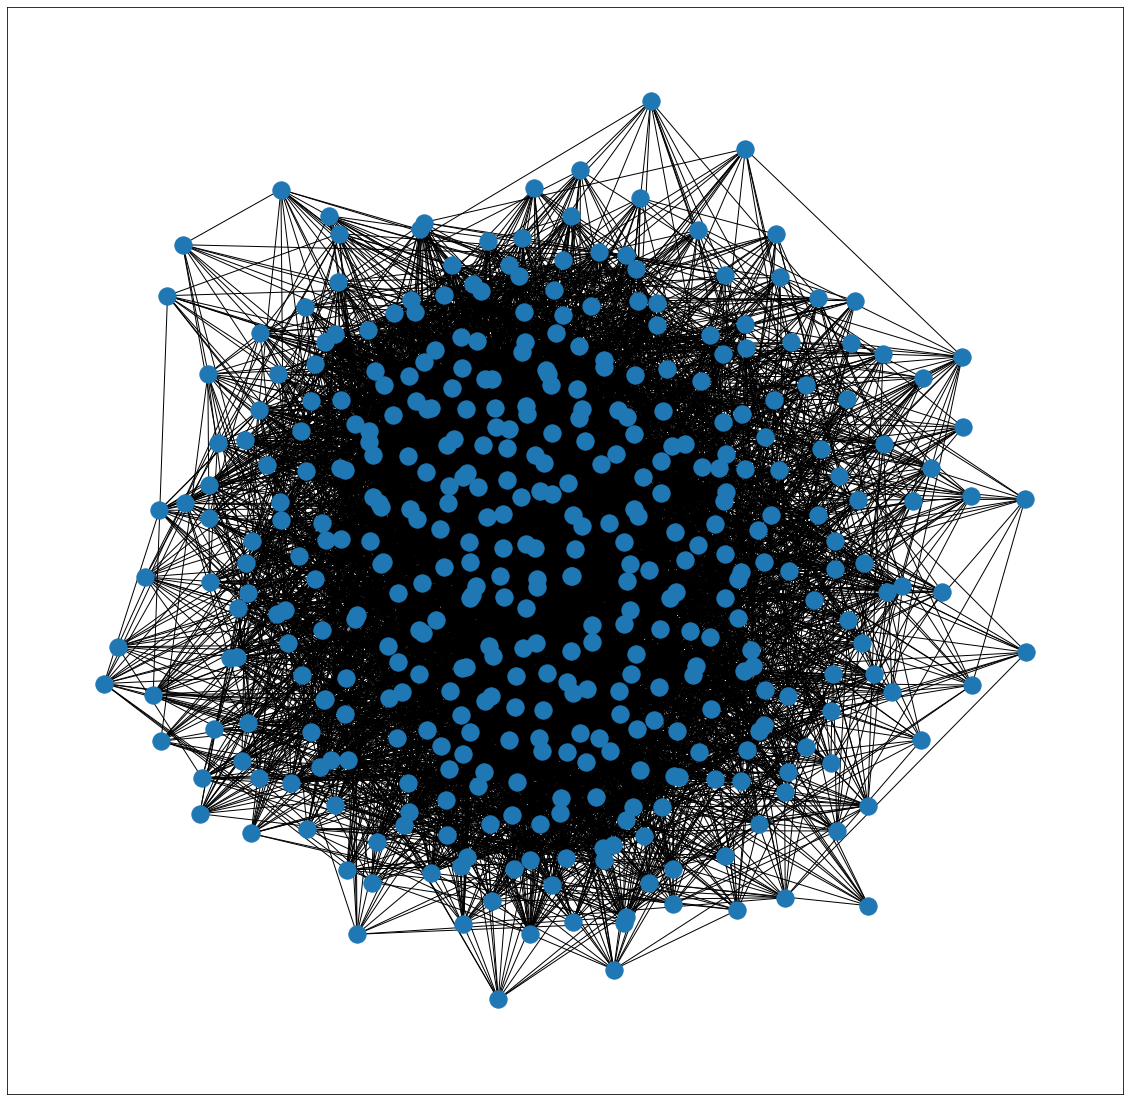

In [207]:
Gcc = sorted(nx.connected_components(trainG), key=len, reverse=True)
G0 = trainG.subgraph(Gcc[0])
#c_nodes = []
#for i in Gcc[0]:
    #c_nodes.append(graph.x[i,34].numpy())
visualize_graph(G0)

### Preferential Attachment

In [119]:
pref = list(nx.preferential_attachment(G, full_sample.T.numpy()))
pref

[(173, 150, 2079),
 (234, 14, 1104),
 (344, 195, 3080),
 (177, 400, 45),
 (9, 319, 2442),
 (83, 382, 1377),
 (348, 195, 800),
 (242, 2, 1363),
 (189, 133, 80),
 (280, 208, 968),
 (311, 128, 1176),
 (10, 90, 975),
 (309, 191, 201),
 (215, 2, 1276),
 (226, 22, 756),
 (366, 23, 429),
 (176, 268, 3080),
 (330, 146, 2288),
 (220, 344, 2541),
 (145, 223, 943),
 (369, 230, 1645),
 (235, 358, 315),
 (72, 144, 42),
 (230, 208, 2068),
 (1, 177, 72),
 (40, 302, 864),
 (190, 266, 819),
 (176, 360, 1210),
 (351, 24, 792),
 (341, 114, 490),
 (351, 104, 627),
 (293, 344, 770),
 (112, 9, 3366),
 (168, 384, 336),
 (235, 237, 819),
 (235, 314, 357),
 (282, 371, 646),
 (213, 291, 1643),
 (86, 346, 60),
 (260, 222, 504),
 (116, 71, 1012),
 (157, 401, 2904),
 (115, 130, 936),
 (282, 267, 731),
 (296, 134, 28),
 (280, 327, 352),
 (376, 65, 408),
 (215, 198, 308),
 (355, 311, 1974),
 (380, 210, 90),
 (341, 325, 2135),
 (275, 325, 2379),
 (261, 213, 1166),
 (245, 213, 3127),
 (195, 396, 320),
 (63, 398, 1769)

### Jaccard

In [190]:
# Calculate Jaccard Coefficient for all node pairs on training graph 
jac = list(nx.jaccard_coefficient(trainG, full_sample.T.numpy()))
jac

[(173, 150, 0.3684210526315789),
 (234, 14, 0.13580246913580246),
 (344, 195, 0.0916030534351145),
 (177, 400, 0.01639344262295082),
 (9, 319, 0.25471698113207547),
 (83, 382, 0.058333333333333334),
 (348, 195, 0.1038961038961039),
 (242, 2, 0.17346938775510204),
 (189, 133, 0.05263157894736842),
 (280, 208, 0.2077922077922078),
 (311, 128, 0.14606741573033707),
 (10, 90, 0.20833333333333334),
 (309, 191, 0.05102040816326531),
 (215, 2, 0.13),
 (226, 22, 0.19753086419753085),
 (366, 23, 0.18309859154929578),
 (176, 268, 0.29245283018867924),
 (330, 146, 0.17094017094017094),
 (220, 344, 0.18803418803418803),
 (145, 223, 0.09183673469387756),
 (369, 230, 0.05825242718446602),
 (235, 358, 0.07352941176470588),
 (72, 144, 0.0425531914893617),
 (230, 208, 0.38095238095238093),
 (1, 177, 0.029850746268656716),
 (40, 302, 0.23943661971830985),
 (190, 266, 0.15384615384615385),
 (176, 360, 0.09473684210526316),
 (351, 24, 0.10112359550561797),
 (341, 114, 0.08333333333333333),
 (351, 104, 0.0

In [191]:
df = pd.DataFrame(jac, columns =['Artist1', 'Artist2', 'Jaccard'])

In [192]:
df["lbl"] = lbls

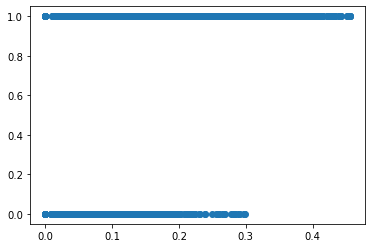

In [193]:
plt.scatter(df["Jaccard"], df["lbl"])

<AxesSubplot:xlabel='Jaccard', ylabel='lbl'>

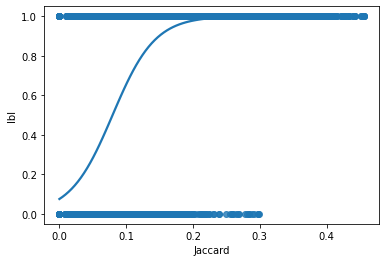

In [194]:
sns.regplot(x=df["Jaccard"], y=df["lbl"], logistic=True, ci=None)

In [195]:
X_train, X_test, y_train, y_test = train_test_split(df[["Jaccard"]], df["lbl"], test_size=0.3, random_state=42)

In [196]:
jac_mode = LogisticRegression(random_state=0).fit(X_train, y_train)
#jac_mode = RandomForestClassifier(random_state=10).fit(X_train, y_train)
#jac_mode = SVC(random_state=10).fit(X_train, y_train)
preds = jac_mode.predict(X_test)
probs = jac_mode.predict_proba(X_test)

In [197]:
accuracy_score(y_test, preds)

0.8031278748850046

In [198]:
roc_auc_score(y_test, preds)

0.8030561931264217

In [199]:
f1_score(y_test, preds)

0.7863205192211682

In [105]:
y_test.shape

(4348,)

### Adamic Adar

In [103]:
adamic = list(nx.adamic_adar_index(trainG, full_sample.T.numpy()))
adamic

[(173, 150, 5.605061087307478),
 (234, 14, 1.0168061680066514),
 (344, 195, 0.9331839284633492),
 (177, 400, 0),
 (9, 319, 4.131579269833532),
 (83, 382, 0.2835784920513334),
 (348, 195, 1.3885679793184338),
 (242, 2, 1.6903107451287582),
 (189, 133, 0.3396232718951086),
 (280, 208, 1.9629445616020873),
 (311, 128, 2.416034869831283),
 (10, 90, 2.2414919072561394),
 (309, 191, 0.2969742043733701),
 (215, 2, 1.539371524304029),
 (226, 22, 2.8881663038607925),
 (366, 23, 1.8029982480402438),
 (176, 268, 5.903339194753563),
 (330, 146, 2.8976735528820905),
 (220, 344, 3.028257629589046),
 (145, 223, 1.1836617497297817),
 (369, 230, 0.23868315209103041),
 (235, 358, 0.25973030217227155),
 (72, 144, 0.24954251462921184),
 (230, 208, 6.554534124941896),
 (1, 177, 0),
 (40, 302, 2.789831710003993),
 (190, 266, 1.9480940209346456),
 (176, 360, 0.8291116316488226),
 (351, 24, 2.027481571351465),
 (341, 114, 1.1635397722259109),
 (351, 104, 0),
 (293, 344, 1.4443466500283875),
 (112, 9, 5.016220

In [104]:
adamic_df = pd.DataFrame(adamic, columns =['Artist1', 'Artist2', 'Adamic'])
adamic_df["lbl"] = lbls

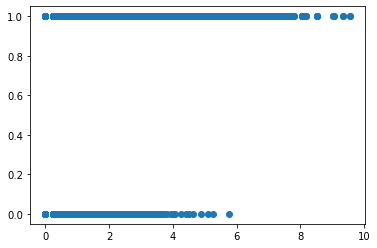

In [105]:
plt.scatter(adamic_df["Adamic"], adamic_df["lbl"])

In [106]:
X_train, X_test, y_train, y_test = train_test_split(adamic_df[["Adamic"]], df["lbl"], test_size=0.3, random_state=42)

In [107]:
adamic_model = LogisticRegression(random_state=0).fit(X_train, y_train)
preds = adamic_model.predict(X_test)
probs = adamic_model.predict_proba(X_test)

In [108]:
accuracy_score(y_test, preds)

0.8217571297148114

In [109]:
roc_auc_score(y_test, preds)

0.8216695949788755

In [110]:
f1_score(y_test, preds)

0.802849147799542

In [149]:
# Using all the data 
adamic_model = LogisticRegression(random_state=0).fit(adamic_df[["Adamic"]], df["lbl"])
preds = adamic_model.predict(df[["lbl"]])
probs = adamic_model.predict_proba(df[["lbl"]])
roc_auc_score(df["lbl"], preds)
#accuracy_score(df["lbl"], preds)
#classification_report(df[["lbl"]], preds)

0.5

<AxesSubplot:xlabel='Adamic', ylabel='lbl'>

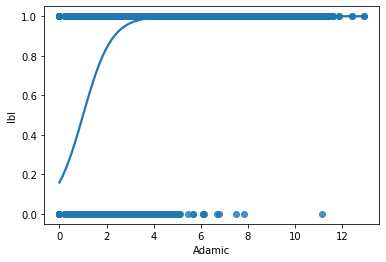

In [135]:
sns.regplot(x=adamic_df["Adamic"], y=adamic_df["lbl"], logistic=True, ci=None)

## Link Prediction with GNN

From https://github.com/AntonioLonga/PytorchGeometricTutorial/blob/main/Tutorial12/Tutorial12%20GAE%20for%20link%20prediction.ipynb

In [292]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [266]:
graph

Data(x=[407, 70], edge_index=[2, 7246])

In [242]:
0.1*7246 # How much of the data should be testing

724.6

In [267]:
data = train_test_split_edges(graph, val_ratio=0.1, test_ratio=0.2)
print(data)

Data(x=[407, 70], val_pos_edge_index=[2, 36], test_pos_edge_index=[2, 1050], train_pos_edge_index=[2, 5074], train_neg_adj_mask=[407, 407], val_neg_edge_index=[2, 36], test_neg_edge_index=[2, 1050])


C:\Users\wchen\.conda\envs\spotify\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


In [268]:
data.train_pos_edge_index.shape[1]/7246 # Verify that the 70/30 split is done 

0.7002484129174718

In [ ]:
# Random Link Split 
tfs = RandomLinkSplit(is_undirected=True, 
                      add_negative_train_samples=True,
                      neg_sampling_ratio=1.0,
                      key = "edge_label", # supervision label
                      disjoint_train_ratio=0,# disjoint mode if > 0
                      )
train_data, val_data, test_data = tfs(graph)

In [79]:
train_data

Data(x=[407, 70], edge_index=[2, 5074], edge_label=[5074], edge_label_index=[2, 5074])

In [80]:
val_data

Data(x=[407, 70], edge_index=[2, 5074], edge_label=[724], edge_label_index=[2, 724])

In [81]:
test_data

Data(x=[407, 70], edge_index=[2, 5798], edge_label=[1448], edge_label_index=[2, 1448])

In [269]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(data.num_features, 128)
        self.conv2 = GCNConv(128, 64)

    def encode(self):
        x = self.conv1(data.x, data.train_pos_edge_index) # convolution 1
        x = x.relu()
        return self.conv2(x, data.train_pos_edge_index) # convolution 2

    def decode(self, z, pos_edge_index, neg_edge_index): # only pos and neg edges
        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1) # concatenate pos and neg edges
        logits = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)  # dot product 
        return logits

    def decode_all(self, z): 
        prob_adj = z @ z.t() # get adj NxN
        return (prob_adj > 0).nonzero(as_tuple=False).t() # get predicted edge_list 

In [270]:
model, data = Net().to(device), data.to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

In [271]:
def get_link_labels(pos_edge_index, neg_edge_index):
    # returns a tensor:
    # [1,1,1,1,...,0,0,0,0,0,..] with the number of ones is equel to the lenght of pos_edge_index
    # and the number of zeros is equal to the length of neg_edge_index
    E = pos_edge_index.size(1) + neg_edge_index.size(1)
    link_labels = torch.zeros(E, dtype=torch.float, device=device)
    link_labels[:pos_edge_index.size(1)] = 1.
    return link_labels


def train():
    model.train()
    
    # Negative sampling for the training set
    neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index, #positive edges
        num_nodes=data.num_nodes, # number of nodes
        num_neg_samples=data.train_pos_edge_index.size(1)) # number of neg_sample equal to number of pos_edges

    optimizer.zero_grad()
    
    z = model.encode() #encode
    link_logits = model.decode(z, data.train_pos_edge_index, neg_edge_index) # decode
    
    link_labels = get_link_labels(data.train_pos_edge_index, neg_edge_index)
    loss = F.binary_cross_entropy_with_logits(link_logits, link_labels) 
    loss.backward()
    optimizer.step()

    return loss

In [272]:
@torch.no_grad()
def test():
    model.eval()
    perfs = []
    for prefix in ["val", "test"]:
        pos_edge_index = data[f'{prefix}_pos_edge_index']
        neg_edge_index = data[f'{prefix}_neg_edge_index']

        z = model.encode() # encode train
        link_logits = model.decode(z, pos_edge_index, neg_edge_index) # decode test or val
        link_probs = link_logits.sigmoid() # apply sigmoid
        link_preds = []
        for p in link_probs:
            if p>0.5:
                link_preds.append(1)
            else:
                link_preds.append(0)
        
        link_labels = get_link_labels(pos_edge_index, neg_edge_index) # get link
        
        perfs.append(roc_auc_score(link_labels.cpu(), link_probs.cpu())) #compute roc_auc score  
        perfs.append(accuracy_score(link_labels.cpu(), link_preds)) # compute accuracy
        perfs.append(f1_score(link_labels.cpu(), link_preds)) # compute f1 score
    return perfs

In [274]:
best_val_perf = test_perf = test_acc = test_f1 = 0
for epoch in range(1, 101):
    train_loss = train()
    val_perf, val_acc, val_f1, tmp_test_perf, tmp_test_acc, tmp_test_f1 = test()
    if val_perf > best_val_perf:
        best_val_perf = val_perf
        test_perf = tmp_test_perf
        test_acc = tmp_test_acc
        test_f1 = tmp_test_f1
    log = 'Epoch: {:03d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}, Test Acc: {:.4f}, Test F1: {:.4f}'
    if epoch <= 2 or epoch % 5 == 0:
        print(log.format(epoch, train_loss, best_val_perf, test_perf, test_acc, test_f1))

Epoch: 001, Loss: 0.4685, Val: 0.9074, Test: 0.9006, Test Acc: 0.7638, Test F1: 0.7962
Epoch: 002, Loss: 0.4690, Val: 0.9074, Test: 0.9006, Test Acc: 0.7638, Test F1: 0.7962
Epoch: 005, Loss: 0.4704, Val: 0.9113, Test: 0.9129, Test Acc: 0.7719, Test F1: 0.8060
Epoch: 010, Loss: 0.4660, Val: 0.9182, Test: 0.9095, Test Acc: 0.7686, Test F1: 0.8020
Epoch: 015, Loss: 0.4673, Val: 0.9182, Test: 0.9095, Test Acc: 0.7686, Test F1: 0.8020
Epoch: 020, Loss: 0.4611, Val: 0.9182, Test: 0.9095, Test Acc: 0.7686, Test F1: 0.8020
Epoch: 025, Loss: 0.4598, Val: 0.9182, Test: 0.9095, Test Acc: 0.7686, Test F1: 0.8020
Epoch: 030, Loss: 0.4589, Val: 0.9182, Test: 0.9095, Test Acc: 0.7686, Test F1: 0.8020
Epoch: 035, Loss: 0.4520, Val: 0.9182, Test: 0.9095, Test Acc: 0.7686, Test F1: 0.8020
Epoch: 040, Loss: 0.4539, Val: 0.9182, Test: 0.9095, Test Acc: 0.7686, Test F1: 0.8020
Epoch: 045, Loss: 0.4654, Val: 0.9190, Test: 0.9197, Test Acc: 0.7752, Test F1: 0.8098
Epoch: 050, Loss: 0.4497, Val: 0.9221, Test

In [127]:
z = model.encode()
final_edge_index = model.decode_all(z)

In [142]:
z.shape

torch.Size([407, 64])

In [140]:
final_edge_index

tensor([[  0,   0,   0,  ..., 406, 406, 406],
        [  0,   1,   2,  ..., 404, 405, 406]])

In [129]:
final_edge_index.shape

torch.Size([2, 69997])

## Link Prediction with Node2Vec

In [91]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'

In [139]:
graph = graph.to(device)

In [92]:
train_graph = train_graph.to(device)

From https://github.com/AntonioLonga/PytorchGeometricTutorial/blob/main/Tutorial12/Tutorial12%20Node2Vec%20for%20label%20prediction.ipynb

In [140]:
model = Node2Vec(graph.edge_index, embedding_dim=128, walk_length=20, context_size=10, walks_per_node=10,
                 num_negative_samples=1, p=1, q=1, num_nodes=graph.x.shape[0], sparse=True).to(device)
loader = model.loader(batch_size=128, shuffle=True, num_workers=4)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

In [141]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [142]:
losses = []
for epoch in range(1, 101):
    loss = train()
    losses.append(loss)
    #acc = test()
    if epoch <= 2 or epoch % 5 == 0:
        print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')

Epoch: 01, Loss: 9.2680
Epoch: 02, Loss: 8.6026
Epoch: 05, Loss: 6.8883
Epoch: 10, Loss: 5.0549
Epoch: 15, Loss: 3.9036
Epoch: 20, Loss: 3.1559
Epoch: 25, Loss: 2.6383
Epoch: 30, Loss: 2.2317
Epoch: 35, Loss: 1.9384
Epoch: 40, Loss: 1.7492
Epoch: 45, Loss: 1.5950
Epoch: 50, Loss: 1.4857
Epoch: 55, Loss: 1.4001
Epoch: 60, Loss: 1.3308
Epoch: 65, Loss: 1.2897
Epoch: 70, Loss: 1.2583
Epoch: 75, Loss: 1.2179
Epoch: 80, Loss: 1.1811
Epoch: 85, Loss: 1.1734
Epoch: 90, Loss: 1.1583
Epoch: 95, Loss: 1.1356
Epoch: 100, Loss: 1.1369


In [143]:
z = model()

In [144]:
#emb_128 = z.detach().cpu().numpy()
emb_128 = z.detach().cpu().numpy()

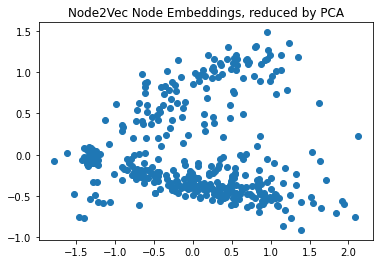

In [145]:
from sklearn.decomposition import PCA
# fit and transform using PCA
pca = PCA(n_components=2)
emb2d = pca.fit_transform(emb_128)


plt.title("Node2Vec Node Embeddings, reduced by PCA")
plt.scatter(emb2d[:,0],emb2d[:,1])
plt.show()

In [146]:
full_sample.T.numpy()

array([[173, 150],
       [234,  14],
       [344, 195],
       ...,
       [286, 322],
       [128, 270],
       [257, 222]], dtype=int64)

In [147]:
emb_128.shape

(407, 128)

In [148]:
graph.edge_index.t().shape

torch.Size([7246, 2])

In [149]:
edge_embedding = []
for u,v in full_sample.T.numpy():
    #edge_embedding.append(np.mean([emb_128[u],emb_128[v]],0))
    #edge_embedding.append(np.mean([emb_128[u],emb_128[v]],0))
    edge_embedding.append(np.multiply(emb_128[u], emb_128[v])) # Hadamard product
edge_embedding = np.array(edge_embedding)

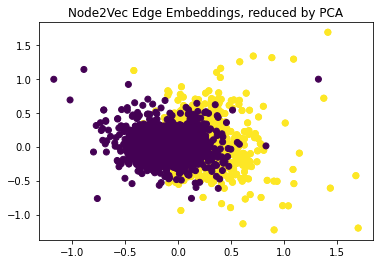

In [150]:
from sklearn.decomposition import PCA
# fit and transform using PCA
pca = PCA(n_components=2)
edge_emb2d = pca.fit_transform(edge_embedding)


plt.title("Node2Vec Edge Embeddings, reduced by PCA")
plt.scatter(edge_emb2d[:,0],edge_emb2d[:,1], c=lbls)
plt.show()

C:\Users\wchen\AppData\Local\Temp/ipykernel_6964/2705336533.py:5: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(lbls, labels = ["Edge Exists"])


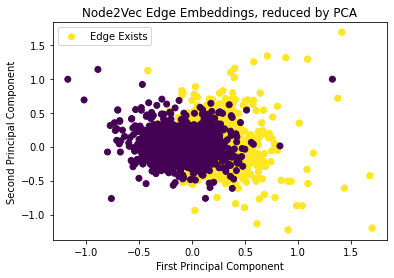

In [163]:
plt.title("Node2Vec Edge Embeddings, reduced by PCA")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.scatter(edge_emb2d[:,0],edge_emb2d[:,1], c=lbls)
plt.legend(lbls, labels = ["Edge Exists"])
plt.show()

We can use different pooling methods (from https://stellargraph.readthedocs.io/en/stable/demos/link-prediction/node2vec-link-prediction.html)

In [ ]:
def operator_hadamard(u, v):
    return u * v


def operator_l1(u, v):
    return np.abs(u - v)


def operator_l2(u, v):
    return (u - v) ** 2

In [134]:
edge_embedding.shape

(14492, 128)

In [151]:
X_train, X_test, y_train, y_test = train_test_split(edge_embedding, lbls, test_size=0.3, random_state=42)

In [152]:
n2v_classifier = LogisticRegression(random_state=0).fit(X_train, y_train)
#n2v_classifier = RandomForestClassifier(random_state=10).fit(X_train, y_train)
#n2v_classifier = SVC(random_state=10).fit(X_train, y_train)
preds = n2v_classifier.predict(X_test)
probs = n2v_classifier.predict_proba(X_test)

In [153]:
roc_auc_score(y_test, preds)

0.9204379265518361

In [154]:
f1_score(y_test, preds)

0.92161304938831

In [155]:
accuracy_score(y_test, preds)

0.9204231830726771

In [248]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       0.90      0.83      0.86      2176
         1.0       0.84      0.91      0.87      2172

    accuracy                           0.87      4348
   macro avg       0.87      0.87      0.87      4348
weighted avg       0.87      0.87      0.87      4348



In [162]:
## Cosine Similarity

In [189]:
import numpy as np
from numpy.linalg import norm
 
# define two lists or array
A = np.array([2,1,2,3,2,9])
B = np.array([3,4,2,4,5,5])
 
print("A:", A)
print("B:", B)
 
# compute cosine similarity
cosine = np.dot(A,B)/(norm(A)*norm(B))
print("Cosine Similarity:", cosine)

A: [2 1 2 3 2 9]
B: [3 4 2 4 5 5]
Cosine Similarity: 0.8188504723485274
